In [1]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, f1_score
from collections import defaultdict
from omegaconf import OmegaConf
import chess
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from consts import *
from dataset import ChessEncoderDataset, collate_fn
import collection_utils 
from collection_utils import make_collections_from_indices
from model import ChessEncoder
from train_and_eval_utils import eval


sns.set_theme()

### Зависимость f1 от p доли читерских ходов в наборах для maia2 и allie детекторов

In [2]:
df = pd.read_csv("../data/processed/tournament/chess_fraud_dataset.csv")

In [3]:
list(df.columns)

['player',
 'game_id',
 'rating_bin',
 'split_by_player',
 'split_by_games',
 'player_color',
 'player_elo',
 'opponent_elo',
 'time_control',
 'half_move',
 'move',
 'move_uci',
 'fen_before',
 'fen_after',
 'clock',
 'clock_delta',
 'is_used',
 'move_thinking_time',
 'move_maia1_1100',
 'fen_maia1_1100',
 'move_maia1_1200',
 'fen_maia1_1200',
 'move_maia1_1300',
 'fen_maia1_1300',
 'move_maia1_1400',
 'fen_maia1_1400',
 'move_maia1_1500',
 'fen_maia1_1500',
 'move_maia1_1600',
 'fen_maia1_1600',
 'move_maia1_1700',
 'fen_maia1_1700',
 'move_maia1_1800',
 'fen_maia1_1800',
 'move_maia1_1900',
 'fen_maia1_1900',
 'move_lc0_1',
 'fen_lc0_1',
 'move_lc0_10',
 'fen_lc0_10',
 'move_lc0_100',
 'fen_lc0_100',
 'maia2_move_probs_1050',
 'maia2_win_probs_1050',
 'move_maia2_1050',
 'fen_maia2_1050',
 'maia2_move_probs_1150',
 'maia2_win_probs_1150',
 'move_maia2_1150',
 'fen_maia2_1150',
 'maia2_move_probs_1250',
 'maia2_win_probs_1250',
 'move_maia2_1250',
 'fen_maia2_1250',
 'maia2_move_prob

In [4]:
DEVICE = "cuda:0"

In [5]:
maia_emb_df = np.load("../data/processed/embeddings/maia2_2050/04_embs_maia2_2050_full.npz")
maia_emb_dict = {}
for column in tqdm(maia_emb_df.files):
    if column in MAIA2_CHEAT_COLUMNS or column in ["fen_before", "fen_after"]:
        maia_emb_dict[column] = maia_emb_df[column]

100%|██████████| 59/59 [02:12<00:00,  2.24s/it]


In [6]:
allie_emb_df = np.load("../data/processed/embeddings/allie_2500/04_embs_allie_2500_full.npz")
allie_emb_dict = {}
for column in tqdm(allie_emb_df.files):
    if column in ALLIE_CHEAT_COLUMNS or column == "move_uci":
        allie_emb_dict[column] = allie_emb_df[column]

100%|██████████| 57/57 [00:16<00:00,  3.50it/s]


In [7]:
with open("data/test_dataset_indices.pickle", mode="rb") as file:
    test = pickle.load(file)

In [8]:
maia_test_data = make_collections_from_indices(maia_emb_dict, test, None)
allie_test_data = make_collections_from_indices(allie_emb_dict, test, None)

Building dataset: 241it [00:07, 31.07it/s]
Building dataset: 241it [00:00, 988.53it/s]


In [9]:
OPTIMAL_N_COLS = 70

In [10]:
maia_model = ChessEncoder()
maia_model.load_state_dict(torch.load(f"checkpoints/choose_n_collections/maia2_2050/{OPTIMAL_N_COLS}.pt", map_location=DEVICE))
maia_model.to(DEVICE)
maia_model.eval()

ChessEncoder(
  (linear): Linear(in_features=1024, out_features=64, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
   

In [11]:
allie_model = ChessEncoder()
allie_model.load_state_dict(torch.load(f"checkpoints/choose_n_collections/allie_2500/{OPTIMAL_N_COLS}.pt", map_location=DEVICE))
allie_model.to(DEVICE)
allie_model.eval()

ChessEncoder(
  (linear): Linear(in_features=1024, out_features=64, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
   

In [14]:
def get_overall_results(model, test_data):
    loss_fn = nn.BCEWithLogitsLoss()
    results = defaultdict(list)
    test_loader = DataLoader(
        ChessEncoderDataset(*test_data),
        BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn
    )
    #loss, f1, precision, recall, f1_macro, f1_weighted
    _, f1, precision, recall, f1_macro, _ = eval(model, loss_fn, test_loader, verbose=False)
    results["f1"].append(f1)
    results["precision"].append(precision)
    results["recall"].append(recall)
    results["f1_macro"].append(f1_macro)
    return results

In [15]:
get_overall_results(maia_model, maia_test_data)

defaultdict(list,
            {'f1': [0.6604970914859862],
             'precision': [0.6061425402107599],
             'recall': [0.7255601659751038],
             'f1_macro': [0.6233996089851914]})

In [16]:
get_overall_results(allie_model, allie_test_data)

defaultdict(list,
            {'f1': [0.6995444191343964],
             'precision': [0.6447165850244927],
             'recall': [0.7645643153526971],
             'f1_macro': [0.6687566560447828]})

In [12]:
def get_f1_list(model, test_data):
    loss_fn = nn.BCEWithLogitsLoss()
    results = defaultdict(list)
    for p_bound in np.arange(MIN_CHEAT_P, MAX_CHEAT_P, 0.1):
        test_loader = DataLoader(
            ChessEncoderDataset(*test_data, p_bounds=(p_bound, p_bound + 0.1)),
            BATCH_SIZE,
            shuffle=False,
            collate_fn=collate_fn
        )
        #loss, f1, precision, recall, f1_macro, f1_weighted
        _, f1, precision, recall, f1_macro, _ = eval(model, loss_fn, test_loader, verbose=False)
        results["f1"].append(f1)
        results["precision"].append(precision)
        results["recall"].append(recall)
        results["f1_macro"].append(f1_macro)
    return results

In [13]:
maia_results = get_f1_list(maia_model, maia_test_data)
allie_results = get_f1_list(allie_model, allie_test_data)

/home/jovyan/miniconda3/envs/rl/lib/python3.11/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


In [ ]:
x = np.arange(0.1, 1.0, 0.1)
assert len(x) == len(maia_results["f1"]), (
    f"x and metric length mismatch: len(x)={len(x)}, "
    f"len(f1)={len(maia_results['f1'])}"
)

bin_labels = [f"({int((v)*100)}%-{int((v+0.1)*100)}%]" for v in x]

for metric in maia_results:
    sns.lineplot(x=x, y=maia_results[metric], label="maia2_2050")
    sns.lineplot(x=x, y=allie_results[metric], label="allie_2500")

    plt.title(f"{metric} Performance vs. Ratio of Cheating Moves in Game Collections")
    plt.xlabel("Ratio of Cheating Moves in Game Collections")
    plt.ylabel(metric)

    plt.xticks(ticks=x, labels=bin_labels, rotation=30)
    plt.legend()

    plt.savefig(
        f"figures/p_experiment/{metric}.pdf",
        format="pdf",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


Ratio доля

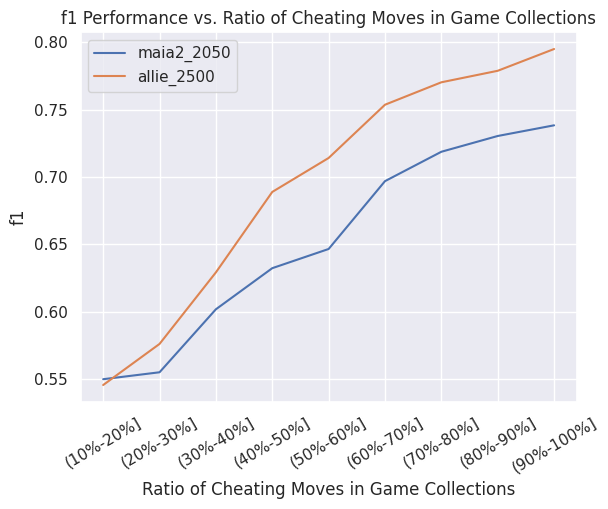

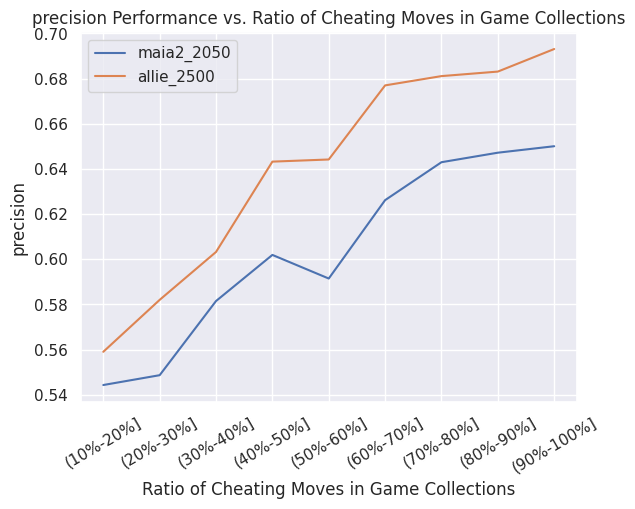

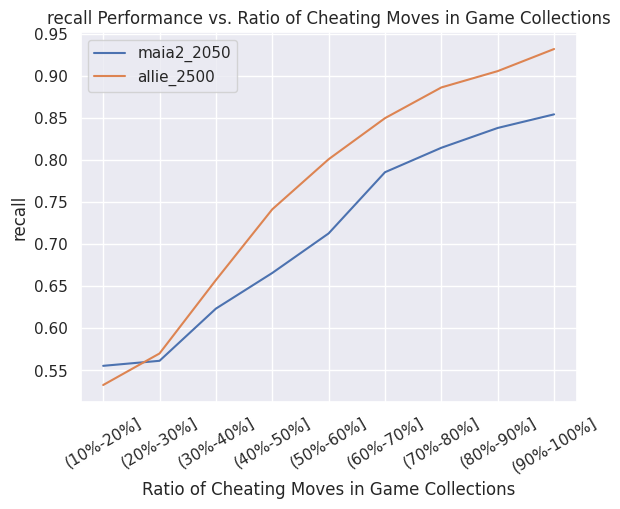

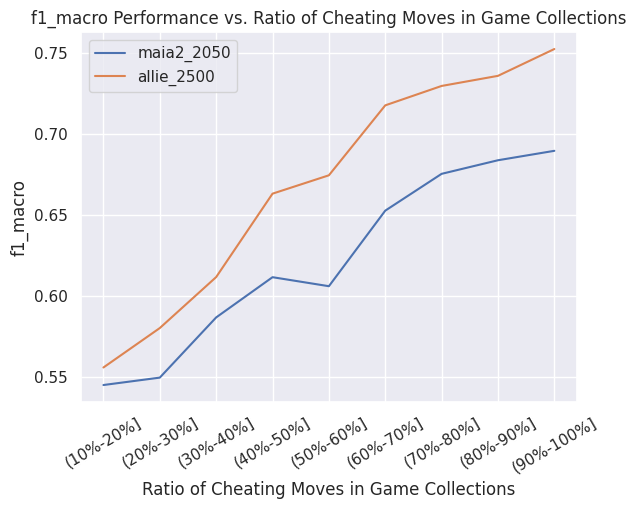

In [21]:
x = np.arange(0.1, 1.0, 0.1)
assert len(x) == len(maia_results["f1"]), (
    f"x and metric length mismatch: len(x)={len(x)}, "
    f"len(f1)={len(maia_results['f1'])}"
)

bin_labels = [f"({int((v)*100)}%-{int((v+0.1)*100)}%]" for v in x]

for metric in maia_results:
    sns.lineplot(x=x, y=maia_results[metric], label="maia2_2050")
    sns.lineplot(x=x, y=allie_results[metric], label="allie_2500")

    plt.title(f"{metric} Performance vs. Ratio of Cheating Moves in Game Collections")
    plt.xlabel("Ratio of Cheating Moves in Game Collections")
    plt.ylabel(metric)

    plt.xticks(ticks=x, labels=bin_labels, rotation=30)
    plt.legend()

    plt.savefig(
        f"figures/p_experiment/{metric}.pdf",
        format="pdf",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


### Зависимость лучшего f1 на тесте от количества наборов на человека в обучающей выборке

In [ ]:
maia_test_loader = DataLoader(
        ChessEncoderDataset(*maia_test_data),
        BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn
    )
allie_test_loader = DataLoader(
        ChessEncoderDataset(*allie_test_data),
        BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn
    )

In [14]:
results = defaultdict(lambda: defaultdict(list))
loss_fn = nn.BCEWithLogitsLoss()
for n_collections in [1] + list(range(10, 110, 10)):
    maia_model = ChessEncoder()
    maia_model.load_state_dict(torch.load(f"checkpoints/choose_n_collections/maia2_2050/{n_collections}.pt", map_location=DEVICE))
    maia_model.to(DEVICE)
    maia_model.eval()

    #loss, f1, precision, recall, f1_macro, f1_weighted
    _, f1, precision, recall, f1_macro, _ = eval(maia_model, loss_fn, maia_test_loader, verbose=False)
    results["maia"]["f1"].append(f1)
    results["maia"]["precision"].append(precision)
    results["maia"]["recall"].append(recall)
    results["maia"]["f1_macro"].append(f1_macro)

    allie_model = ChessEncoder()
    allie_model.load_state_dict(torch.load(f"checkpoints/choose_n_collections/allie_2500/{n_collections}.pt", map_location=DEVICE))
    allie_model.to(DEVICE)
    allie_model.eval()

    #loss, f1, precision, recall, f1_macro, f1_weighted
    _, f1, precision, recall, f1_macro, _ = eval(allie_model, loss_fn, allie_test_loader, verbose=False)
    results["allie"]["f1"].append(f1)
    results["allie"]["precision"].append(precision)
    results["allie"]["recall"].append(recall)
    results["allie"]["f1_macro"].append(f1_macro)

/home/jovyan/miniconda3/envs/rl/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/jovyan/miniconda3/envs/rl/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/jovyan/miniconda3/envs/rl/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor i

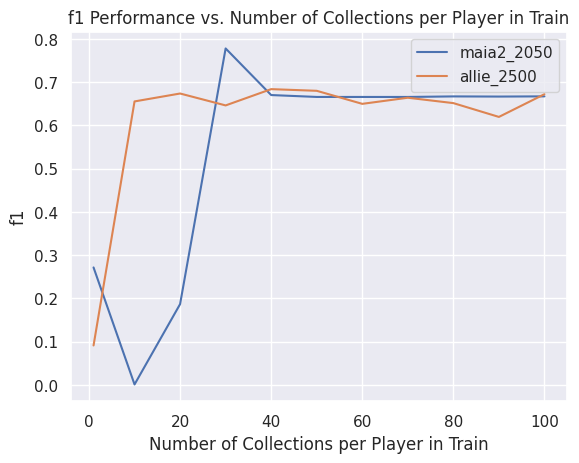

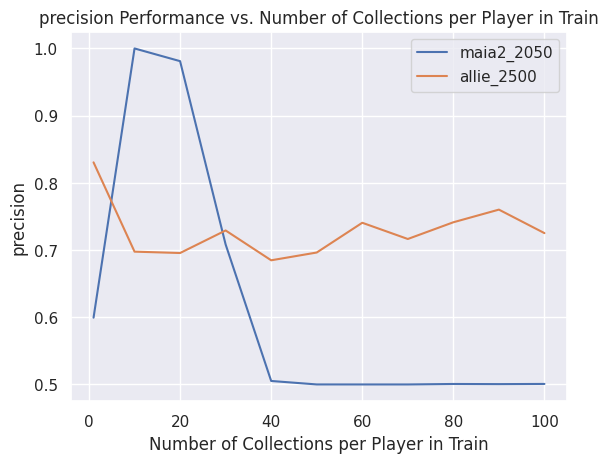

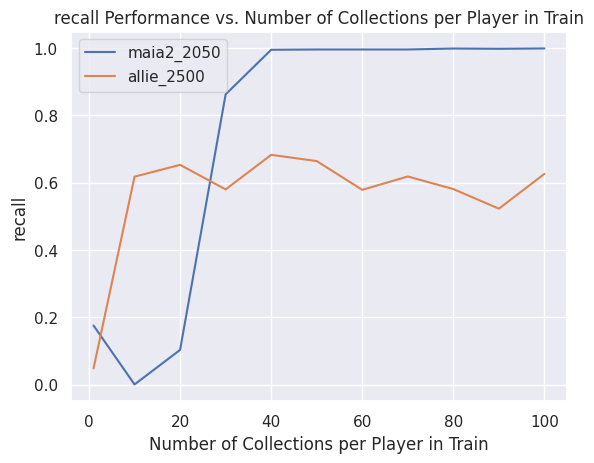

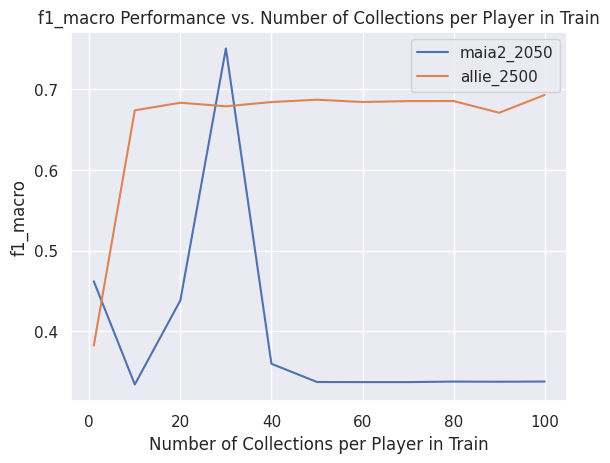

In [15]:
x = [1] + list(range(10, 110, 10))
for metric in results["maia"]:
    sns.lineplot(x=x, y=results["maia"][metric], label="maia2_2050")
    sns.lineplot(x=x, y=results["allie"][metric], label="allie_2500")
    plt.title(f"{metric} Performance vs. Number of Collections per Player in Train")
    plt.legend()
    plt.xlabel("Number of Collections per Player in Train")
    plt.ylabel(metric)
    plt.savefig(f"figures/n_collections/{metric}.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()